# Installs

In [ ]:
!pip install pytorch-lightning
!pip install torch-geometric
!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.1.0+cu118.html
!pip install jax
!pip install --upgrade jax jaxlib==0.4.20+cpu -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip install tensorcircuit
!pip install qiskit
!pip install matplotlib
!pip install pylatexenc
!pip install tabulate
!pip install kmapper
!pip install qutip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.7 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.1.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 36.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.8/887.8 kB 21.8 MB/s eta 0:00:00
Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
ERROR: Ignored the following yanked versions: 0.4.32
ERROR: Could not find a version that satisfies the requirement jaxlib==0.4.20+c

In [ ]:
pip install --upgrade jax jaxlib==0.4.35

  Using cached jax-0.4.35-py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.3/87.3 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 49.1 MB/s eta 0:00:00
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.4.33
    Uninstalling jaxlib-0.4.33:
      Successfully uninstalled jaxlib-0.4.33
  Attempting uninstall: jax
    Found existing installation: jax 0.4.33
    Uninstalling jax-0.4.33:
      Successfully uninstalled jax-0.4.33


In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1' # Comment this to use gpu

In [ ]:
import torch_geometric
import torch_geometric.nn as geom_nn
import torch_geometric.data as geom_data
import torch_geometric.transforms as T

import torch
import torch.nn as nn
import qutip
from qutip import Bloch
import matplotlib
from matplotlib import pyplot as plt
import sklearn as skl
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc

import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelSummary
from pytorch_lightning.callbacks import Callback

from pytorch_lightning.loggers import WandbLogger

import jax
import jax.numpy as jnp
import tensorcircuit as tc

import numpy as np
import pandas as pd
import kmapper as km
import networkx as nx
from copy import copy

import warnings
warnings.filterwarnings('ignore')

torch.set_float32_matmul_precision("medium")
K = tc.set_backend("jax")
print(tc.__version__)

/usr/local/lib/python3.10/dist-packages/torch_geometric/typing.py:68: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: libcudart.so.11.0: cannot open shared object file: No such file or directory
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/usr/local/lib/python3.10/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.10/dist-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.10/dist-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /usr/local/lib/python3.10/dist-packages/torch_cluster/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importin

0.12.0


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool

In [ ]:
jax.devices()

[CpuDevice(id=0)]

In [ ]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cpu


# VQC

In [ ]:
def get_circ(nqubits, nlayers, x, weights):
    # print(x.shape, x.val, x[1])
    c = tc.Circuit(nqubits)
    for i in range(nqubits):
        c.rx(i, theta=x[i])
    for j in range(nlayers):
        for i in range(nqubits - 1):
            c.cnot(i, i + 1)
        for i in range(nqubits):
            c.rx(i, theta=weights[2 * j, i])
            c.ry(i, theta=weights[2 * j + 1, i])
    return c

In [ ]:
def circuit_wrapper(nqubits, nlayers):

    def qpred(x, weights):

        circuit = get_circ(nqubits, nlayers, x, weights)

        # print(K.real(jnp.array(circuit.expectation_ps(z=[1]))))
        return K.real(jnp.array([circuit.expectation_ps(z=[i]) for i in range(nqubits)]))

    # Now Vectorization,expects batch_x to have shape (batch_size, nqubits)
    #!!!!!!! qpred_vmap is a function that is a vectorized version of qpred !!!!!!!!!!
    qpred_vmap = K.vmap(qpred, vectorized_argnums=0)

    # Now We make it into a PyTorch-compatible type
    qpred_batch = tc.interfaces.torch_interface(qpred_vmap, jit=True)

    return qpred_batch

In [ ]:
import numpy as np
import tensorcircuit as tc

# Example parameters
nqubits = 6
nlayers = 2

# Initialize some test data
x = np.random.uniform(0, 2 * np.pi, nqubits)  # Random input angles for RX gates
weights = np.random.uniform(0, 2 * np.pi, (2 * nlayers, nqubits))  # Random weights for parameterized gates

# Use the `get_circ` function to build a circuit
circuit = get_circ(nqubits, nlayers, x, weights)

# Test the first line: expectation value for a specific qubit
specific_qubit_expval = circuit.expectation_ps(z=[1])  # Measure qubit 1 in Z-basis
print(f"Expectation value for qubit 1: {np.real(specific_qubit_expval)}")

# Test the second line: expectation values for all qubits
all_qubits_expvals = [circuit.expectation_ps(z=[i]) for i in range(nqubits)]  # Measure all qubits in Z-basis
all_qubits_expvals_real = np.real(all_qubits_expvals)
print(f"Expectation values for all qubits: {all_qubits_expvals_real}")


Expectation value for qubit 1: -0.1162077784538269
Expectation values for all qubits: [ 0.106534   -0.11620778 -0.01538211  0.4072671  -0.02008659 -0.02719238]


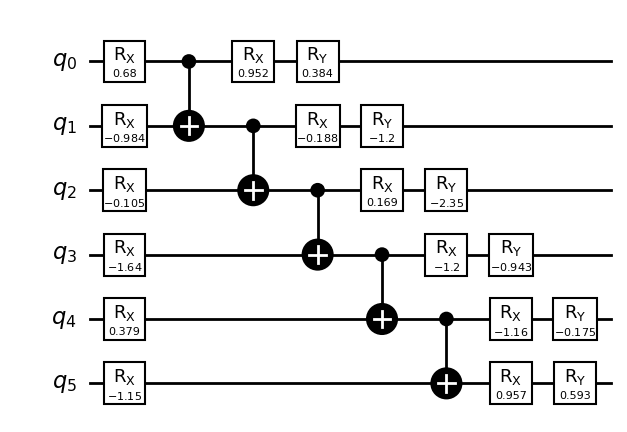

In [ ]:
# Test the AD capacity of the PyTorch function
nqubits = 6
nlayers = 1
w = torch.randn([2 * nlayers, nqubits])
dummy_x = torch.randn([3, nqubits])

fig = get_circ(nqubits, nlayers, dummy_x[0], w).draw(output='mpl', style="bw", fold=0)
fig.savefig('Quantum_circ.pdf', format='pdf', dpi=300, bbox_inches='tight');
fig

In [ ]:
qpred_batch = circuit_wrapper(nqubits, nlayers)

In [ ]:
w.requires_grad_()
with torch.set_grad_enabled(True):
    print(dummy_x.shape, dummy_x)
    yps = qpred_batch(dummy_x, w)
    loss = torch.sum(yps)
    loss.backward()
print(w.grad, yps)

torch.Size([3, 6]) tensor([[ 0.6803, -0.9845, -0.1048, -1.6353,  0.3792, -1.1498],
        [ 0.5480,  0.6787, -0.9594, -1.0543, -0.5914, -0.6419],
        [ 1.7767, -1.2713,  0.0194, -1.3963,  0.4961,  0.1099]])
Traced<ShapedArray(float32[])>with<BatchTrace(level=2/0)> with
  val = Traced<ShapedArray(float32[3])>with<DynamicJaxprTrace(level=1/0)>
  batch_dim = 0
tensor([[-1.0768,  0.0703,  0.0889,  0.0824,  0.1097, -0.0376],
        [-0.3105,  0.9464,  0.5230,  0.0436,  0.0085, -0.0665]]) tensor([[ 0.4183,  0.1537, -0.2976, -0.0058, -0.0101, -0.0209],
        [ 0.4593,  0.2374, -0.2653,  0.0397,  0.0616,  0.1233],
        [-0.1100, -0.0216,  0.0420, -0.0022, -0.0036, -0.0037]],
       grad_fn=<FunBackward>)


In [ ]:
class QuantumNet(nn.Module):
    def __init__(self, nqubits, nlayers):
        super().__init__()
        self.q_weights = torch.nn.Parameter(torch.randn([2 * nlayers, nqubits]))
        self.qpred_batch = circuit_wrapper(nqubits, nlayers)

        self.nqubits = nqubits
        self.nlayers = nlayers

    def forward(self, inputs):
#         print("Inside quantum net", inputs.shape)
        ypred = self.qpred_batch(inputs, self.q_weights)
#         print("output of qpred", ypred.shape)
        return ypred

In [ ]:
net = QuantumNet(6, 2)
out = net(dummy_x)
print(out)
print(out.shape)

Traced<ShapedArray(float32[])>with<BatchTrace(level=2/0)> with
  val = Traced<ShapedArray(float32[3])>with<DynamicJaxprTrace(level=1/0)>
  batch_dim = 0
tensor([[ 0.0832, -0.3246,  0.0482,  0.3304,  0.0180,  0.0325],
        [ 0.2080,  0.1212,  0.2536,  0.3386, -0.0324, -0.0356],
        [ 0.0066, -0.5456, -0.0151,  0.3180,  0.0890,  0.1764]],
       grad_fn=<FunBackward>)
torch.Size([3, 6])


In [ ]:
class QGCNConv(geom_nn.GCNConv):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        improved: bool = False,
        cached: bool = False,
        add_self_loops: bool = True,
        normalize: bool = True,
        bias: bool = True,
        nlayers = 1,
        **kwargs,
    ):
        super().__init__(in_channels,
                        out_channels,
                        improved,
                        cached,
                        add_self_loops,
                        normalize,
                        bias,
                        **kwargs)
        self.lin = QuantumNet(in_channels, nlayers)

In [ ]:
import torch
from torch_geometric.data import Data
from torch_geometric.utils import dense_to_sparse

# Mock input features
x_mock = torch.randn(10, 16).float()  # 10 nodes, 16 features per node

# Mock edge index (example: fully connected graph or sparse representation)
# Creating a fully connected graph adjacency matrix for simplicity
adj_matrix = torch.rand(10, 10) - torch.eye(10)  # 10 nodes, fully connected, no self-loops
edge_index, _ = dense_to_sparse(adj_matrix)  # Convert dense adjacency matrix to edge_index format

# Initialize the quantum layer
quantum_layer = QGCNConv(16, 16, nlayers=1)

# Forward pass with both x and edge_index
output = quantum_layer(x_mock, edge_index)  # Pass both x and edge_index
print(output)


Traced<ShapedArray(float32[])>with<BatchTrace(level=2/0)> with
  val = Traced<ShapedArray(float32[10])>with<DynamicJaxprTrace(level=1/0)>
  batch_dim = 0
tensor([[ 0.0181, -0.1082,  0.1841, -0.0534, -0.0282,  0.0371,  0.0151, -0.0144,
          0.0052,  0.0050,  0.0007,  0.0047,  0.0003,  0.0004,  0.0022, -0.0014],
        [ 0.0181, -0.1082,  0.1841, -0.0534, -0.0282,  0.0371,  0.0151, -0.0144,
          0.0052,  0.0050,  0.0007,  0.0047,  0.0003,  0.0004,  0.0022, -0.0014],
        [ 0.0181, -0.1082,  0.1841, -0.0534, -0.0282,  0.0371,  0.0151, -0.0144,
          0.0052,  0.0050,  0.0007,  0.0047,  0.0003,  0.0004,  0.0022, -0.0014],
        [ 0.0181, -0.1082,  0.1841, -0.0534, -0.0282,  0.0371,  0.0151, -0.0144,
          0.0052,  0.0050,  0.0007,  0.0047,  0.0003,  0.0004,  0.0022, -0.0014],
        [ 0.0181, -0.1082,  0.1841, -0.0534, -0.0282,  0.0371,  0.0151, -0.0144,
          0.0052,  0.0050,  0.0007,  0.0047,  0.0003,  0.0004,  0.0022, -0.0014],
        [ 0.0181, -0.1082,  0.1

In [ ]:
edge_index

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4,
         4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7,
         7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9,
         9, 9, 9, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3,
         4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7,
         8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1,
         2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5,
         6, 7, 8, 9]])

In [ ]:
gnn_layer_by_name = {
    "QGCN": QGCNConv,
    "GCN" : geom_nn.GCNConv,
    "GAT": geom_nn.GATConv,
    "GraphConv": geom_nn.GraphConv,
    "SAGE": geom_nn.SAGEConv
}

# Datasets

## Functions

In [ ]:
def count_fraud_percentage(df, fraud_col='isFraud'):
    """
    Calculate the count and percentage of fraud cases in a DataFrame.

    """

    fraud_count = df[fraud_col].sum()

    total_count = len(df)
    fraud_percentage = (fraud_count / total_count) * 100

    return fraud_count, fraud_percentage

In [ ]:
from imblearn.over_sampling import SMOTE
import pandas as pd

from imblearn.over_sampling import SMOTE
import pandas as pd

def balance_with_smote(df, target_col='isFraud', smote_ratio=0.2, random_state=42):
    """Apply SMOTE to increase the minority class size by a specified ratio."""
    X = df.drop(columns=[target_col])
    y = df[target_col]

    # Apply SMOTE with a limited ratio
    smote = SMOTE(sampling_strategy=smote_ratio, random_state=random_state)
    X_resampled, y_resampled = smote.fit_resample(X, y)

    balanced_df = pd.DataFrame(X_resampled, columns=X.columns)
    balanced_df[target_col] = y_resampled
    return balanced_df

## PaySim Dataset

#### Loading PaySim Dataset

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Install the Kaggle library
!pip install kaggle

# Upload kaggle.json file
from google.colab import files
files.upload()  # This will prompt you to upload kaggle.json

# Make a directory for Kaggle and move the file there
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Now you can download the dataset
!kaggle datasets download -d ealaxi/paysim1 -p /content/datasets --unzip

print("Dataset downloaded to: /content/datasets")

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/ealaxi/paysim1
License(s): CC-BY-SA-4.0
100% 178M/178M [00:01<00:00, 111MB/s]
100% 178M/178M [00:01<00:00, 138MB/s]
Dataset downloaded to: /content/datasets


In [ ]:
# df=pd.read_csv("/content/datasets/PS_20174392719_1491204439457_log.csv",delimiter=',')
# nRowsRead = 1000000
# big_df = pd.read_csv("/content/datasets/PS_20174392719_1491204439457_log.csv",delimiter=',',nrows=nRowsRead)
nRowsRead = 100000
small_df = pd.read_csv("/content/datasets/PS_20174392719_1491204439457_log.csv",delimiter=',',nrows=nRowsRead)

In [ ]:
# print(df.head())
# print(big_df.head())
print(small_df.head())

   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  


#### Cleaning

In [ ]:
df_cleaned = small_df.loc[(small_df['type'].isin(['CASH_OUT', 'TRANSFER'])),:]

In [ ]:
df_cleaned.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,1,TRANSFER,181.00,C1305486145,181.0,0.0,C553264065,0.0,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.0,C38997010,21182.0,0.00,1,0
15,1,CASH_OUT,229133.94,C905080434,15325.0,0.0,C476402209,5083.0,51513.44,0,0
19,1,TRANSFER,215310.30,C1670993182,705.0,0.0,C1100439041,22425.0,0.00,0,0
24,1,TRANSFER,311685.89,C1984094095,10835.0,0.0,C932583850,6267.0,2719172.89,0,0


In [ ]:
df_cleaned.drop(columns=['nameOrig','nameDest','isFlaggedFraud'],inplace=True)

In [ ]:
df_cleaned['type'] = small_df['type'].map({'CASH_OUT': 0, 'TRANSFER': 1})

In [ ]:
df_cleaned

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
2,1,1.0,181.00,181.0,0.0,0.00,0.00,1
3,1,0.0,181.00,181.0,0.0,21182.00,0.00,1
15,1,0.0,229133.94,15325.0,0.0,5083.00,51513.44,0
19,1,1.0,215310.30,705.0,0.0,22425.00,0.00,0
24,1,1.0,311685.89,10835.0,0.0,6267.00,2719172.89,0
...,...,...,...,...,...,...,...,...
99988,10,0.0,410128.06,99507.0,0.0,2220.00,893352.38,0
99990,10,0.0,231788.22,24902.0,0.0,0.00,183153.72,0
99991,10,0.0,222796.86,7487.0,0.0,120054.97,52596.25,0
99992,10,0.0,173609.46,50462.0,0.0,39334.53,118762.90,0


Now we have to balance the dataset since the original is way to unbalanced. To do this we use the smote methodology

In [ ]:
df_smote_balanced = balance_with_smote(df_cleaned, target_col='isFraud', smote_ratio=0.2, random_state=42)
fraud_count_smote, fraud_percentage_smote = count_fraud_percentage(df_smote_balanced)
print(f"After SMOTE - Fraudulent: {fraud_count_smote}, Fraud Percentage: {fraud_percentage_smote:.2f}%")

After SMOTE - Fraudulent: 7839, Fraud Percentage: 16.67%


In [ ]:
final_df=df_smote_balanced

# Models

In [ ]:
import torch.nn as nn
import torch_geometric.nn as geom_nn  # Assuming PyTorch Geometric is being used

class GraphGNNModel(nn.Module):

    def __init__(self, c_in, c_hidden, c_out, num_layers=1, dp_rate_linear=0.5, dp_rate=0.3, **kwargs):
        """
        Inputs:
            c_in - Dimension of input features
            c_hidden - Dimension of hidden features
            c_out - Dimension of output features (usually number of classes)
            num_layers - Number of "hidden" graph layers
            dp_rate_linear - Dropout rate before the linear layer (usually much higher than inside the GNN)
            dp_rate - Dropout rate inside the GNN layers
            kwargs - Additional arguments for the GNNModel object
        """
        super().__init__()
        self.embed = nn.Linear(c_in, c_hidden)

        self.qgcn_layer = QGCNConv(in_channels=c_hidden, out_channels=c_hidden, bias=False)

        # Classical GCN layers
        self.gcn1 = geom_nn.GCNConv(
            in_channels=c_hidden,
            out_channels=c_hidden,
            bias=False
        )
        self.gcn2 = geom_nn.GCNConv(
            in_channels=c_hidden,
            out_channels=c_hidden,
            bias=False
        )

        # Dropout layers
        self.dropout = nn.Dropout(dp_rate)

        # Output head
        self.head = nn.Sequential(
            nn.Linear(c_hidden, c_out)
        )

    def forward(self, x, edge_index, batch_idx):
        # Embedding layer
        x = self.embed(x)

        # Quantum GCN layer
        x = self.qgcn_layer(x, edge_index)
        # x = torch.relu(x)
        x = self.dropout(x)

        # Classical GCN layers
        x = self.gcn1(x, edge_index)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.gcn2(x, edge_index)
        x = torch.relu(x)
        x = self.dropout(x)

        # Global pooling
        x = geom_nn.global_mean_pool(x, batch_idx)

        # Output layer
        x = self.head(x)
        return x



# Training

#### Real Test

In [ ]:
final_df = final_df.sort_values(by='step').astype(float)

In [ ]:
final_df

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,1.0,1.0,181.00,181.00,0.00,0.00,0.00,1.0
241,1.0,1.0,483544.30,0.00,0.00,876379.19,2107778.11,0.0
242,1.0,1.0,326349.91,0.00,0.00,778150.49,1254956.07,0.0
243,1.0,1.0,84212.94,53199.00,0.00,0.00,84212.94,0.0
171,1.0,1.0,635507.97,0.00,0.00,834457.23,1567434.81,0.0
...,...,...,...,...,...,...,...,...
33763,10.0,0.0,560560.83,59713.00,0.00,660780.55,2510400.85,0.0
33764,10.0,0.0,559518.84,7370.00,0.00,28305.90,587824.75,0.0
33765,10.0,0.0,173961.22,606220.43,432259.21,2551751.31,2725712.53,0.0
33767,10.0,0.0,487795.44,495.00,0.00,627581.75,1115377.19,0.0


In [ ]:
import numpy as np
import torch
from torch_geometric.data import Data

def preprocess_data(final_df):
    data_list = []

    # Ensure `final_df` is a NumPy array
    if isinstance(final_df, pd.DataFrame):
        final_df = final_df.to_numpy()  # Convert to NumPy array

    for row in final_df:
        features = row[:-1]  # All but the last column
        label = row[-1]  # Last column

        # Convert to tensors
        features = torch.tensor(features, dtype=torch.float)
        label = torch.tensor(label, dtype=torch.long)

        # Define fully connected edge_index
        num_features = len(features)
        edge_index = torch.combinations(torch.arange(num_features), r=2).t()
        edge_index = torch.cat([edge_index, edge_index.flip(0)], dim=1)  # Bidirectional

        # Node features must be 2D
        x = features.unsqueeze(1)  # Shape: [num_features, 1]

        # Create PyTorch Geometric Data object
        data = Data(x=x, edge_index=edge_index, y=label.unsqueeze(0))
        data_list.append(data)

    return data_list


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import global_mean_pool
from torch_geometric.loader import DataLoader
import pytorch_lightning as pl
from torch.optim import Adam

In [ ]:
from torch.utils.data import DataLoader, Dataset

In [ ]:
data_list = preprocess_data(final_df)

In [ ]:
from sklearn.model_selection import train_test_split
from torch_geometric.loader import DataLoader

# Split the data into training, validation, and testing sets
train_data_list, val_data_list = train_test_split(train_data_list, test_size=0.2, random_state=42)

# Define batch size
batch_size = 32  # Adjust as needed

# Create DataLoaders for batching
train_loader = DataLoader(train_data_list, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data_list, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data_list, batch_size=batch_size, shuffle=False)

# Optional: Print sizes to verify
print(f"Number of training samples: {len(train_data_list)}")
print(f"Number of validation samples: {len(val_data_list)}")
print(f"Number of testing samples: {len(test_data_list)}")


Number of training samples: 30104
Number of validation samples: 7526
Number of testing samples: 9408


In [ ]:
def train(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # Calculate accuracy
        pred = out.argmax(dim=1)
        correct += (pred == data.y).sum().item()
        total += data.y.size(0)
    avg_loss = total_loss / len(loader)
    accuracy = correct / total
    return avg_loss, accuracy

def validate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data.x, data.edge_index, data.batch)
            loss = criterion(out, data.y)
            total_loss += loss.item()
            pred = out.argmax(dim=1)
            correct += (pred == data.y).sum().item()
            total += data.y.size(0)
    avg_loss = total_loss / len(loader)
    accuracy = correct / total
    return avg_loss, accuracy

def test(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data.x, data.edge_index, data.batch)
            pred = out.argmax(dim=1)
            correct += (pred == data.y).sum().item()
            total += data.y.size(0)
    return correct / total




In [ ]:
import torch.optim as optim
import torch.nn as nn

# Define model parameters
c_in = data_list[0].num_node_features
c_hidden = c_in  # Hidden dimension size
c_out = 2  # Number of classes in your dataset

# Initialize the model
model = GraphGNNModel(c_in=c_in, c_hidden=c_hidden, c_out=c_out)
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
from torch.optim.lr_scheduler import StepLR

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=20, gamma=0.5)  # Halve the learning rate every 20 epochs

num_epochs = 5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f'Epoch {epoch:03d} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} '
          f'| Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}')


Epoch 001 | Train Loss: 0.4522 | Train Acc: 0.8323 | Val Loss: 0.4370 | Val Acc: 0.8419
Epoch 002 | Train Loss: 0.4521 | Train Acc: 0.8323 | Val Loss: 0.4369 | Val Acc: 0.8419
Epoch 003 | Train Loss: 0.4521 | Train Acc: 0.8323 | Val Loss: 0.4367 | Val Acc: 0.8419
Epoch 004 | Train Loss: 0.4522 | Train Acc: 0.8323 | Val Loss: 0.4368 | Val Acc: 0.8419
Epoch 005 | Train Loss: 0.4522 | Train Acc: 0.8323 | Val Loss: 0.4370 | Val Acc: 0.8419


In [ ]:
# After training loop
test_accuracy, all_preds, all_labels = test(model, test_loader, device)
print(f'Test Accuracy: {test_accuracy:.4f}')

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Display confusion matrix
class_names = ['Class 0', 'Class 1']  # Replace with your class names
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Print classification report
report = classification_report(all_labels, all_preds, target_names=class_names)
print(report)

TypeError: cannot unpack non-iterable float object

### Old Training Method

In [ ]:
class QuantumGraphClassifier(pl.LightningModule):
    def __init__(self, model, lr=1e-3):
        super().__init__()
        self.model = model
        self.loss_fn = nn.CrossEntropyLoss()  # For binary classification, adjust if necessary
        self.lr = lr

                # Print the model structure
        print("Model Structure:\n", self.model)

    def forward(self, x, edge_index, batch_idx):
        return self.model(x, edge_index, batch_idx)

    def training_step(self, batch, batch_idx):
        out = self(batch.x, batch.edge_index, batch.batch)
        loss = self.loss_fn(out, batch.y)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        out = self(batch.x, batch.edge_index, batch.batch)
        loss = self.loss_fn(out, batch.y)
        acc = (out.argmax(dim=1) == batch.y).float().mean()

        # Log the loss and accuracy
        self.log("val_loss", loss)
        self.log("val_acc", acc)

        # Print the loss and accuracy for each batch
        # print(f"Batch {batch_idx} - Validation Loss: {loss.item()}, Validation Accuracy: {acc.item()}")


    def test_step(self, batch, batch_idx):
        out = self(batch.x, batch.edge_index, batch.batch)
        loss = self.loss_fn(out, batch.y)
        acc = (out.argmax(dim=1) == batch.y).float().mean()
        self.log("test_loss", loss)
        self.log("test_acc", acc)

    def configure_optimizers(self):
        return Adam(self.parameters(), lr=self.lr)


In [ ]:
# Instantiate the model
c_in, c_hidden, c_out = 7, 64, 2  # Example dimensions
epochs=1
model = GraphGNNModel(c_in=c_in, c_hidden=c_hidden, c_out=c_out)

# Wrap the model with the QuantumGraphClassifier
quantum_model = QuantumGraphClassifier(model)
# Instantiate the PyTorch Lightning trainer
trainer = pl.Trainer(max_epochs=epochs, accelerator="gpu" if torch.cuda.is_available() else "cpu")

# Train the model
trainer.fit(quantum_model, train_loader, test_loader)

# Test the model
trainer.test(quantum_model, test_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | GraphGNNModel    | 8.8 K  | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
8.8 K     Trainable params
0         Non-trainable params
8.8 K     Total params
0.035     Total estimated model params size (MB)
12        Modules in train mode
0         Modules in eval mode


Model Structure:
 GraphGNNModel(
  (embed): Linear(in_features=7, out_features=64, bias=True)
  (gcn1): GCNConv(64, 64)
  (gcn2): GCNConv(64, 64)
  (dropout): Dropout(p=0.3, inplace=False)
  (head): Sequential(
    (0): Linear(in_features=64, out_features=2, bias=True)
  )
)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

RuntimeError: mat1 and mat2 shapes cannot be multiplied (224x1 and 64x64)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Testing function to evaluate accuracy, classification report, and confusion matrix
def test_model(pl_model, test_loader):
    pl_model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Disable gradient computation for testing
        for batch in test_loader:
            # Forward pass using x, edge_index, and batch for the model
            out = pl_model(batch.x, batch.edge_index, batch.batch)

            # Get predictions and append them along with true labels
            preds = out.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())  # Move to CPU and store predictions
            all_labels.extend(batch.y.cpu().numpy())  # Move to CPU and store true labels

    # Print the classification report
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=["0", "1"], digits=4))

    # Print the confusion matrix
    print("\nConfusion Matrix:")
    cm = confusion_matrix(all_labels, all_preds, labels=[0, 1])
    print(cm)

# Assuming `model` is defined and `test_loader` is the DataLoader for test data
test_model(model, test_loader)


In [ ]:
# Access the QGCNConv layers in the GNNModel module of GraphGNNModel
for idx, layer in enumerate(model.GNN.layers):
    if isinstance(layer, QGCNConv):
        print(f"Parameters of QGCNConv layer {idx}:")
        for name, param in layer.named_parameters():
            print(f"{name}: {param.data}")
